# Detección de genomas anómalos de SARS-CoV-2 por medio de algoritmos de aprendizaje no supervisados 

# Todas las anomalías

En esta tesis se empleó una metodología que consideró 11 criterios para determinar la clasificación de un genoma como una anomalía. Como se mencionó previamente, solo se consideraron como anomalías aproximadamente el 0.01\% (entre 50 y 52 genomas) de las instancias más divergentes según la mayoría de estos criterios. Esto se hizo con el propósito de evitar una sobrerrepresentación de genomas de la Ciudad de México.

## ➤ Bibliotecas necesarias y configuración inicial

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Configuración para el estilo a utilizar en las gráficas.

In [2]:
BACK = 'white'
FRONT = (230/255,236/255,245/255)

plt.rc('figure', facecolor=BACK, edgecolor='white')
plt.rc('axes', facecolor=FRONT, edgecolor='white', labelsize=14, labelweight='medium', titlesize=18, grid=True, axisbelow=True)
plt.rc('grid', color='white')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)

---

## ➤ Criterios emplados para detectar anomalías

1. Los genomas con la menor **distancia euclidiana** entre su uso de codones y el uso de codones del genoma humano.
2. Los genomas con la mayor **distancia de Wasserstein** entre su uso de codones y el uso de codones del genoma humano.
3. Los genomas con la mayor **entropía** en su uso de codones.
4. Los genomas con la mayor **distancia log-cociente esperada** en el espacio de uso de codones.
5. Los genomas con la mayor distancia esperada en la proyección de **PCA**.
6. Los genomas con la mayor distancia esperada en el espacio generado por **Isomap**.
7. Los genomas clasificados como anomalías por el algoritmo de **DBSCAN**.
8. Los genomas con el mayor puntaje de anomalía obtenido por el algoritmo de **k-medias**, aplicado a subconjuntos por estado.
9. Los genomas con el mayor puntaje de anomalía obtenido por el algoritmo de **k-medias**, aplicado a subconjuntos por periodos de tiempo.    
10. Los genomas con el mayor puntaje de anomalía obtenido por el algoritmo del **valor atípico local (LOF)**.
11. Los genomas con el mayor puntaje de anomalía obtenido por el algoritmo del **bosque de aislamiento**.

In [3]:
stats_data = pd.read_csv('Archivos/codon_usage_stats.csv', parse_dates=['Date'])
pca_data = pd.read_csv('Archivos/codon_usage_pca.csv', parse_dates=['Date'])
isomap_data = pd.read_csv('Archivos/codon_usage_isomap_078.csv', parse_dates=['Date'])
dbscan_data = pd.read_csv('Archivos/DBSCAN_labels.csv', parse_dates=['Date'])
if_data = pd.read_csv('Archivos/IF_labels.csv', parse_dates=['Date'])
lof_data = pd.read_csv('Archivos/LOF_labels.csv', parse_dates=['Date'])
kmeans_states_data = pd.read_csv('Archivos/kmeans_states_labels.csv', parse_dates=['Date'])
kmeans_periods_data = pd.read_csv('Archivos/kmeans_periods_labels.csv', parse_dates=['Date'])

In [4]:
top = 50
columns = ['Date','Virus','Description','State']

anomalies_euclidean = stats_data.nsmallest(top, 'Human_Euclidean')[columns]
anomalies_wasserstein = stats_data.nlargest(top, 'Human_Wasserstein')[columns]
anomalies_entropy = stats_data.nlargest(top, 'Entropy')[columns]
anomalies_logratio = stats_data.nlargest(top, 'Mean_Logratio_dist')[columns]

anomalies_pca = pca_data.nlargest(top, 'Mean_Dist')[columns]
anomalies_isomap = isomap_data.nlargest(top, 'Mean_Dist')[columns]

#anomalies_dbscan1 = dbscan_data.query('Label1 == -1')[columns]
anomalies_dbscan = dbscan_data.query('Label2 == -1')[columns]
anomalies_if = if_data.nlargest(top, 'Anomaly_Scores')[columns]
anomalies_lof = lof_data.nlargest(top, 'Anomaly_Scores')[columns]
anomalies_kmeans_states = kmeans_states_data.nlargest(top, 'Anomaly_Score')[columns]
anomalies_kmeans_periods = kmeans_periods_data.nlargest(top, 'Anomaly_Score')[columns]

anomalies = pd.concat([anomalies_euclidean,
                       anomalies_wasserstein,
                       anomalies_entropy,
                       anomalies_logratio,
                       anomalies_pca,
                       anomalies_isomap,
                       anomalies_dbscan,
                       anomalies_if, 
                       anomalies_lof, 
                       anomalies_kmeans_states, 
                       anomalies_kmeans_periods])
anomalies['Anomaly_Count'] = 1
anomalies = anomalies.groupby(columns, as_index=False).count()

ids = anomalies['Virus']
all_anomalies = stats_data.query('Virus not in @ids')[columns]
all_anomalies['Anomaly_Count'] = 0

all_anomalies = pd.concat([all_anomalies, anomalies]).reset_index(drop=True)
all_anomalies['Anomaly'] = np.where(all_anomalies['Anomaly_Count'],1, 0)

El siguiente dataframe muestra los primeros 30 genomas identificados por la mayoría de estos criterios como anomalías.

In [5]:
all_anomalies.nlargest(30, 'Anomaly_Count').reset_index(drop=True)

,Date,Virus,Description,State,Anomaly_Count,Anomaly
0,2021-07-07,EPI_ISL_3055556,PUE-LABOPAT-71_26796,Puebla,10,1
1,2021-07-09,EPI_ISL_3055553,PUE-LABOPAT-88_27202,Puebla,10,1
2,2021-06-10,EPI_ISL_3055582,PUE-LABOPAT-17_20285,Puebla,9,1
3,2021-07-06,EPI_ISL_3055554,PUE-LABOPAT-70_26696,Puebla,9,1
4,2021-07-09,EPI_ISL_3055552,PUE-LABOPAT-91_27256,Puebla,9,1
5,2021-07-09,EPI_ISL_3055557,PUE-LABOPAT-85_27142,Puebla,9,1
6,2021-07-12,EPI_ISL_3055561,PUE-LABOPAT-92_21416,Puebla,9,1
7,2021-10-19,EPI_ISL_6570840,CHP_InDRE_FB49584_S9184,Chiapas,9,1
8,2021-12-17,EPI_ISL_8184724,PUE-VB21-86817-LABOPAT,Ciudad de México,9,1
9,2021-12-21,EPI_ISL_8184727,PUE-VE21-87386-LABOPAT,Puebla,9,1


In [6]:
import matplotlib.dates as mdates
half_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%m-%y")

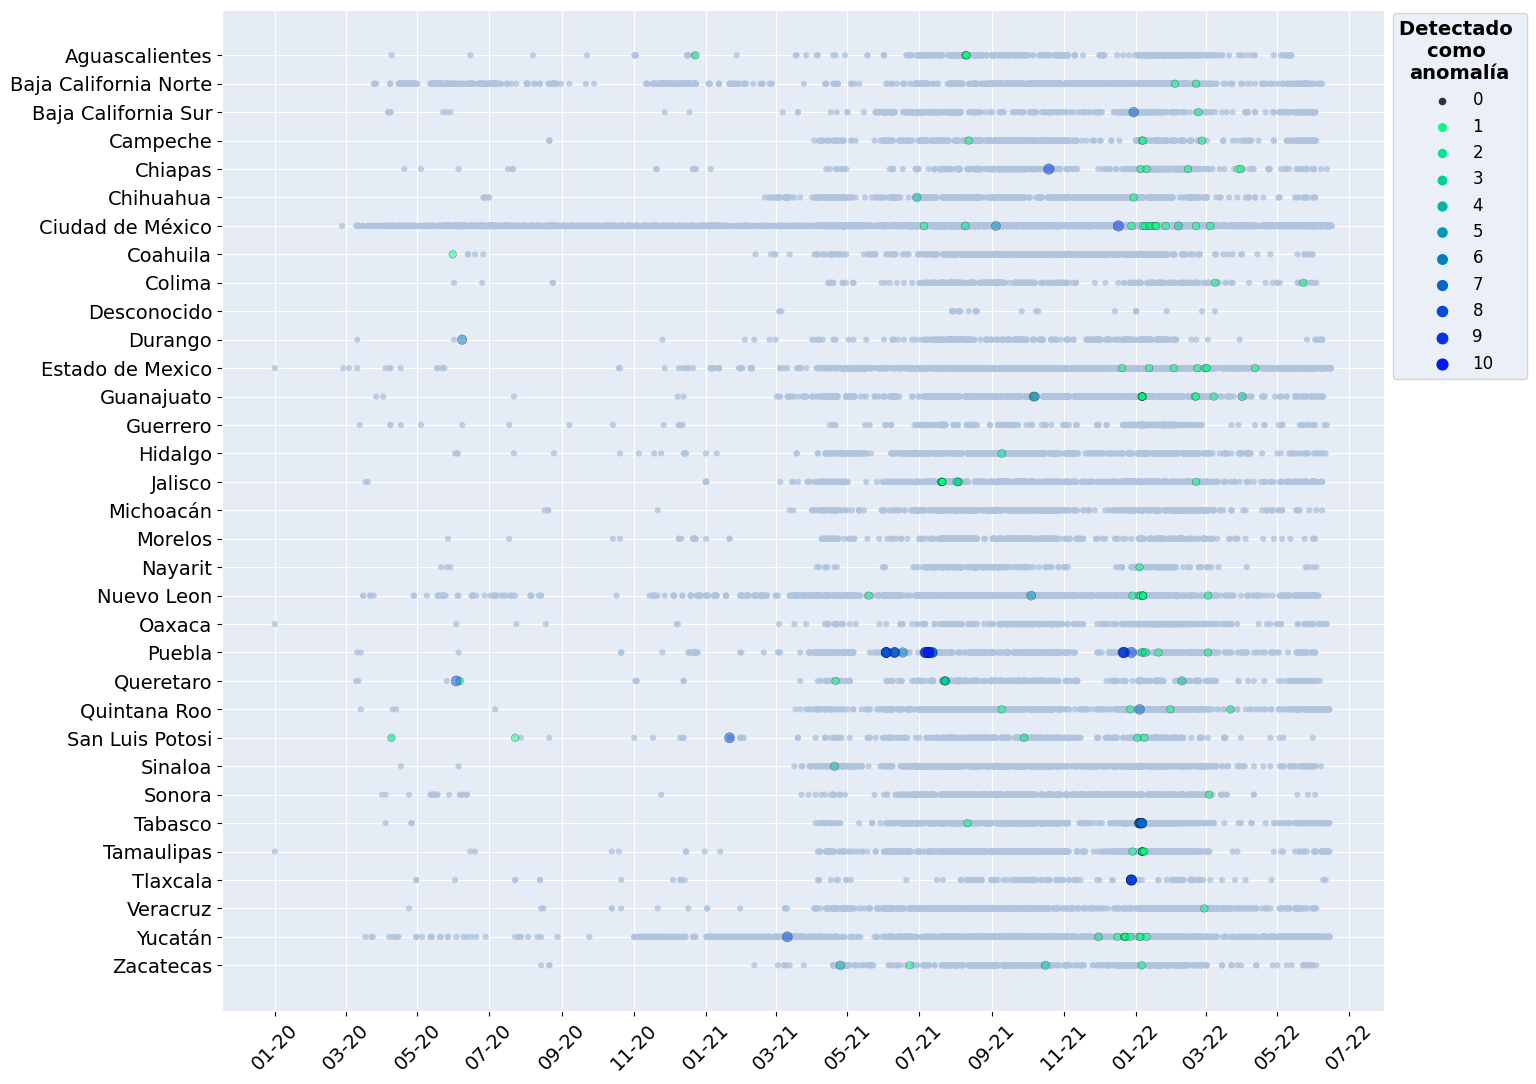

In [7]:
fig, ax = plt.subplots(figsize=(15,13))

sns.scatterplot(data=all_anomalies.sort_values(['State','Anomaly_Count']).query('Anomaly_Count == 0'), 
                x='Date', y='State', size='Anomaly_Count', sizes=(20,50), alpha=0.8, 
                linewidth=0, color='lightsteelblue', legend='full', ax=ax);
sns.scatterplot(data=all_anomalies.sort_values(['State','Anomaly_Count']).query('Anomaly_Count > 0'), 
                x='Date', y='State', size='Anomaly_Count', sizes=(30,60), hue='Anomaly_Count', edgecolor='black',
                linewidth=0.3, palette='winter_r', hue_norm=(1,11), legend='full', alpha=0.5, ax=ax);
legend = ax.legend(bbox_to_anchor=(1,1.005), title='Detectado \ncomo \nanomalía', 
                   title_fontproperties=dict(weight='bold', size=14), fontsize=12);
legend.get_title().set_ha('center')
ax.xaxis.set_major_locator(half_year_locator)
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.set_xlabel('');
ax.set_ylabel('');
ax.tick_params(axis='both', labelsize=14)
fig.savefig(f'Images/all_anomalies_date_v_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig(f'Images(jpg)/all_anomalies_date_v_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

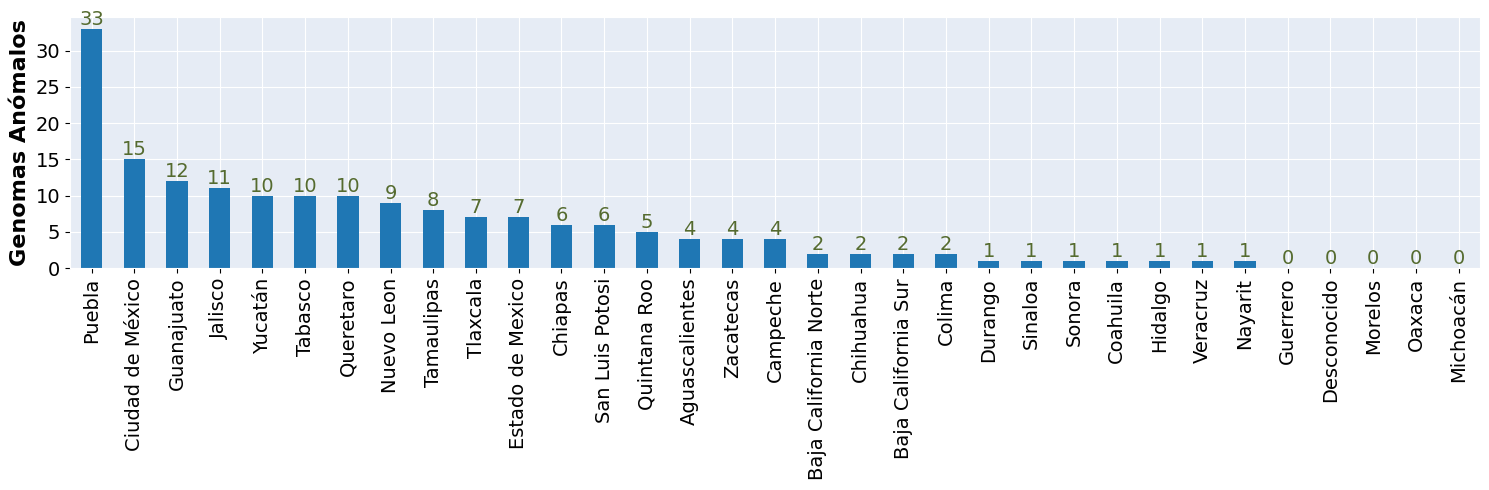

In [8]:
fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
bar = (
    all_anomalies
    [['State','Anomaly']]
    .groupby('State', as_index=False)
    .sum()
    .sort_values('Anomaly', ascending=False)
    .plot.bar(x='State', y='Anomaly', ax=ax,
              legend=False, xlabel='', ylabel='', fontsize=14)
);
ax.bar_label(bar.containers[0], color='darkolivegreen', fontsize=14);
ax.set_ylabel('Genomas Anómalos', fontdict=dict(size=16, weight='bold'));
fig.savefig(f'Images/all_anomalies_by_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig(f'Images(jpg)/all_anomalies_by_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

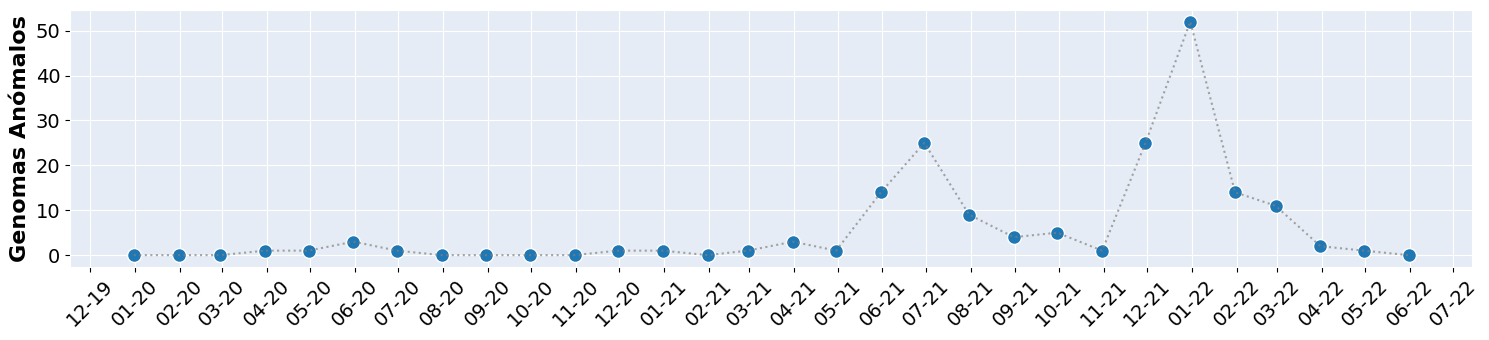

In [9]:
fig, ax = plt.subplots(figsize=(15,3.5), tight_layout=True)

temp = (
    all_anomalies
    [['Date','Anomaly']]
    .resample('M', on='Date', label='left')
    .sum()
    .reset_index()
)

locator = mdates.MonthLocator(interval=1)
formatter = mdates.DateFormatter("%m-%y")
ax.plot(temp.Date, temp.Anomaly, linestyle=':', color='gray', alpha=0.7)
ax.scatter(temp.Date, temp.Anomaly, s=100, edgecolor='white', linewidth=1)
ax.xaxis.set_major_locator(locator)
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='both', labelsize=14)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Genomas Anómalos', fontdict=dict(size=16, weight='bold'));
fig.savefig(f'Images/all_anomalies_by_date.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig(f'Images(jpg)/all_anomalies_by_date.jpg', dpi=1000, bbox_inches='tight', facecolor='none')